In [14]:
import torch
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch import nn
from torchvision.utils import make_grid
from torch.utils.data import random_split, dataloader
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [15]:
# transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(0.5,0.5)
# ])
transforms = transforms.ToTensor()

In [16]:
datasets = MNIST(root='data/', transform=transforms, download=True)


In [17]:
test_dataset = MNIST(root='data/', train=False, transform = transforms)

In [18]:
batch_size=128
train_dl = dataloader.DataLoader(datasets, batch_size,shuffle= True, pin_memory=True, num_workers= 2)
# test_dl = dataloader.DataLoader(datasets, batch_size,shuffle= False, pin_memory=True, num_workers= 2)
len(train_dl)

469

images shape is torch.Size([128, 1, 28, 28])


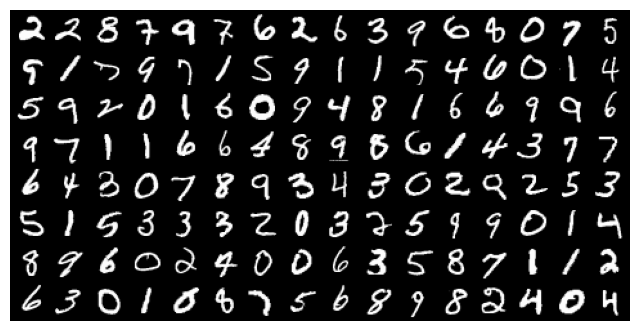

In [19]:
for images, labels in train_dl:
  print(f'images shape is {images.shape}')
  plt.figure(figsize=(8,16))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
  break

In [20]:
class AutoEncoder(nn.Module):
  def __init__(self,input_size):
    super(AutoEncoder, self).__init__()
    self.Encoder = nn.Sequential(
                                  nn.Linear(input_size, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 12)
    )
    self.Decoder = nn.Sequential(
                                nn.Linear(12,256),
                                nn.ReLU(),
                                nn.Linear(256, input_size),
                                nn.Sigmoid()
    )
  def forward(self, x):
    encodings = self.Encoder(x)
    decodings = self.Decoder(encodings)
    return decodings

In [21]:
AutoEncoder = AutoEncoder(28*28)

In [22]:
AutoEncoder

AutoEncoder(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=12, bias=True)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl_cuda = DeviceDataLoader(train_dl, device)
# test_dl_cuda = DeviceDataLoader(test_dl, device)
AutoEncoder = to_device(AutoEncoder,device)

In [26]:
num_epochs = 20
lr = 1e-4
loss_func = nn.MSELoss()
optim = torch.optim.Adam(AutoEncoder.parameters(), lr=lr)
train_loss=[]
output_list = []
for epoch in range(num_epochs):
  epoch_loss = 0
  for batch in train_dl_cuda:
    images,_ = batch
    images = images.view(images.size(0), -1)
    outputs = AutoEncoder(images)
    loss = loss_func(outputs, images)
    epoch_loss += loss.item()
    optim.zero_grad()
    loss.backward()
    optim.step()

  epoch_loss /= len(train_dl)
  train_loss.append(epoch_loss)
  output_list.append((epoch,outputs,images))
  print(f'Epoch[{epoch+1}/{num_epochs}], loss: {epoch_loss:4f}')






Epoch[1/20], loss: 0.086778
Epoch[2/20], loss: 0.043930
Epoch[3/20], loss: 0.033493
Epoch[4/20], loss: 0.029009
Epoch[5/20], loss: 0.026244
Epoch[6/20], loss: 0.024475
Epoch[7/20], loss: 0.023354
Epoch[8/20], loss: 0.022522
Epoch[9/20], loss: 0.021840
Epoch[10/20], loss: 0.021272
Epoch[11/20], loss: 0.020776
Epoch[12/20], loss: 0.020346
Epoch[13/20], loss: 0.019958
Epoch[14/20], loss: 0.019614
Epoch[15/20], loss: 0.019304
Epoch[16/20], loss: 0.019020
Epoch[17/20], loss: 0.018758
Epoch[18/20], loss: 0.018514
Epoch[19/20], loss: 0.018290
Epoch[20/20], loss: 0.018079


Text(0.5, 1.0, 'Losses vs Epochs')

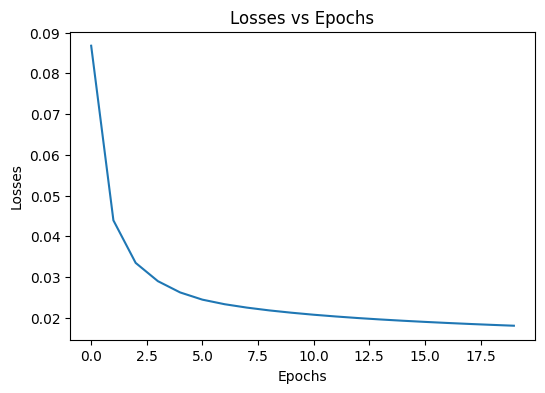

In [74]:
plt.figure(figsize=(6,4))
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title("Losses vs Epochs")


In [66]:
def show_images(output_list, index_1,index_2):
  imgs = output_list[index_1][index_2].cpu().detach().numpy()
  print(f'output shape is>>> {imgs.shape}')
  imgs=imgs.reshape(-1,28,28)
  print(f'reshaped output shape is>>> {imgs.shape}')
  plt.figure(figsize=(9,3))
  for i in range(1,28):
    plt.subplot(3, 9, i)
    plt.imshow(imgs[i - 1])
    i +=1


output shape is>>> (96, 784)
reshaped output shape is>>> (96, 28, 28)


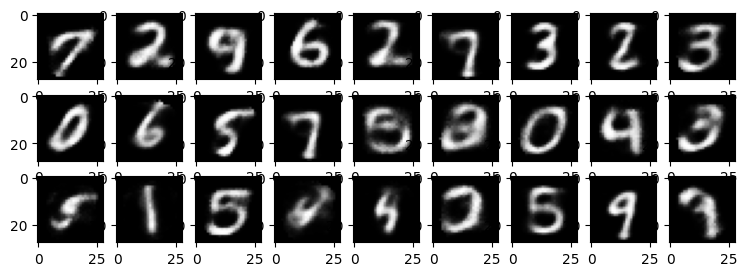

In [67]:
show_images(output_list,5,1)

output shape is>>> (96, 784)
reshaped output shape is>>> (96, 28, 28)


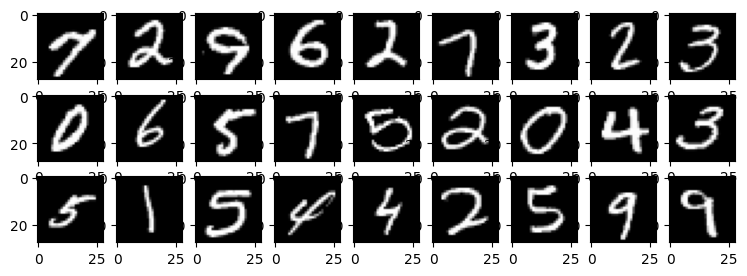

In [68]:
show_images(output_list,5,2)